## Objectifs du projet

### 🎯 Objectifs métier
- Comprendre la dégradation de la ponctualité au départ de Paris-CDG pendant l'été 2022.
- Identifier les plages horaires, terminaux et causes ayant le plus contribué aux retards.
- Mesurer l’impact de l’incident bagages du 2 juillet 2022.
- Proposer des recommandations opérationnelles concrètes pour éviter de revivre cette situation.

### 🎯 Objectifs data
- Construire un dataset pédagogique inspiré de données réelles d’exploitation aérienne.
- Nettoyer, préparer et enrichir les données (feature engineering).
- Calculer les KPI opérationnels : OTP, retard moyen, part des retards > 15 / 30 / 60 minutes.
- Segmenter la performance selon des axes pertinents (heure, terminal, cause).
- Comparer deux périodes : **avant** et **après** l'incident bagages.


In [31]:
# 01_exploration_vols_cdg_ete2022.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Affichage plus lisible
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)

# Chemins des dossiers
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"

print("Projet root :", PROJECT_ROOT)
print("Dossier data :", DATA_DIR)


Projet root : /Users/godwincherubin/Documents/GitHub/cdg-summer-2022-delay-analysis
Dossier data : /Users/godwincherubin/Documents/GitHub/cdg-summer-2022-delay-analysis/data


## 1. Construction pédagogique du jeu de données

Dans un contexte réel, les données viendraient d'un data warehouse (SQL, fichiers opérationnels, etc.).  
Ici, je construis un jeu de données simplifié **inspiré de la crise de l'été 2022 à CDG** :

- `vols_cdg_ete2022` : un échantillon de vols au départ de CDG entre juin et août 2022,
- `causes_retard` : la cause principale de retard pour chaque vol (bagages, handling, ATC, météo, etc.).

Ces données servent de support pédagogique pour reproduire un vrai raisonnement d'analyste opérations.


In [9]:
# Création d'un petit échantillon de vols CDG été 2022

data_vols = [
    # flight_id, date, jour, mois, heure prévue, heure réelle, terminal, zone, dest, région, type_vol, appareil
    ("ES001", "2022-06-15", "Mercredi", 6, "06:30", "07:05", "2E", "2E_L", "JFK", "Amériques", "LC", "B777"),
    ("ES002", "2022-06-15", "Mercredi", 6, "07:10", "07:20", "2F", "2F1", "FCO", "Europe", "CC", "A320"),
    ("ES003", "2022-06-15", "Mercredi", 6, "08:00", "08:55", "2F", "2F2", "LHR", "Europe", "CC", "A321"),
    ("ES004", "2022-06-20", "Lundi",    6, "18:10", "19:05", "2E", "2E_M", "JFK", "Amériques", "LC", "A350"),
    ("ES005", "2022-06-20", "Lundi",    6, "19:30", "20:50", "2G", None,   "MUC", "Europe", "CC", "E190"),
    ("ES006", "2022-07-02", "Samedi",   7, "06:10", "07:20", "2E", "2E_L", "JNB", "Afrique", "LC", "B777"),
    ("ES007", "2022-07-02", "Samedi",   7, "06:45", "08:05", "2E", "2E_L", "JFK", "Amériques", "LC", "B777"),
    ("ES008", "2022-07-02", "Samedi",   7, "07:20", "08:10", "2F", "2F1", "LHR", "Europe", "CC", "A320"),
    ("ES009", "2022-07-05", "Mardi",    7, "09:00", "09:40", "2F", "2F2", "MAD", "Europe", "CC", "A321"),
    ("ES010","2022-07-05", "Mardi",    7, "18:30", "19:50", "2E", "2E_M", "JFK", "Amériques", "LC", "A350"),
    ("ES011","2022-07-10","Dimanche",  7, "06:00", "07:35", "2E", "2E_L", "LAX", "Amériques", "LC", "B777"),
    ("ES012","2022-07-10","Dimanche",  7, "06:20", "06:50", "2F", "2F1", "AMS", "Europe", "CC", "A320"),
    ("ES013","2022-07-18","Lundi",     7, "20:45", "21:05", "2G", None,   "LYS", "Europe", "CC", "E190"),
    ("ES014","2022-08-01","Lundi",     8, "08:10", "08:15", "2F", "2F1", "BCN", "Europe", "CC", "A320"),
    ("ES015","2022-08-01","Lundi",     8, "17:55", "19:20", "2E", "2E_M", "JFK", "Amériques", "LC", "B777"),
]

cols_vols = [
    "flight_id",
    "date_vol",
    "jour_semaine",
    "mois",
    "heure_depart_prevue",
    "heure_depart_reelle",
    "terminal",
    "zone_gate",
    "destination",
    "region_destination",
    "type_vol",
    "type_appareil",
]

df_vols = pd.DataFrame(data_vols, columns=cols_vols)
df_vols


,flight_id,date_vol,jour_semaine,mois,heure_depart_prevue,heure_depart_reelle,terminal,zone_gate,destination,region_destination,type_vol,type_appareil
0,ES001,2022-06-15,Mercredi,6,06:30,07:05,2E,2E_L,JFK,Amériques,LC,B777
1,ES002,2022-06-15,Mercredi,6,07:10,07:20,2F,2F1,FCO,Europe,CC,A320
2,ES003,2022-06-15,Mercredi,6,08:00,08:55,2F,2F2,LHR,Europe,CC,A321
3,ES004,2022-06-20,Lundi,6,18:10,19:05,2E,2E_M,JFK,Amériques,LC,A350
4,ES005,2022-06-20,Lundi,6,19:30,20:50,2G,None,MUC,Europe,CC,E190
5,ES006,2022-07-02,Samedi,7,06:10,07:20,2E,2E_L,JNB,Afrique,LC,B777
6,ES007,2022-07-02,Samedi,7,06:45,08:05,2E,2E_L,JFK,Amériques,LC,B777
7,ES008,2022-07-02,Samedi,7,07:20,08:10,2F,2F1,LHR,Europe,CC,A320
8,ES009,2022-07-05,Mardi,7,09:00,09:40,2F,2F2,MAD,Europe,CC,A321
9,ES010,2022-07-05,Mardi,7,18:30,19:50,2E,2E_M,JFK,Amériques,LC,A350


## 2. Calcul du retard départ et catégorisation

Dans les opérations aériennes, la ponctualité départ (OTP) est un KPI central.  
Un vol est considéré **"on time"** si le retard au départ est **≤ 15 minutes**.

Dans cette section, je :
- convertis les horaires prévus / réels en `datetime`,
- calcule le retard au départ en minutes (`retard_depart_min`),
- classe les retards par catégorie (`A_0_15`, `B_15_30`, `C_30_60`, `D_60_plus`).


In [10]:
# Conversion des heures en datetime pour calculer le retard
df_vols["datetime_depart_prevu"] = pd.to_datetime(df_vols["date_vol"] + " " + df_vols["heure_depart_prevue"])
df_vols["datetime_depart_reel"] = pd.to_datetime(df_vols["date_vol"] + " " + df_vols["heure_depart_reelle"])

# Retard en minutes
df_vols["retard_depart_min"] = (df_vols["datetime_depart_reel"] - df_vols["datetime_depart_prevu"]).dt.total_seconds() / 60
df_vols["retard_depart_min"] = df_vols["retard_depart_min"].astype(int)

def classer_retard(mins):
    if mins <= 15:
        return "A_0_15"
    elif mins <= 30:
        return "B_15_30"
    elif mins <= 60:
        return "C_30_60"
    else:
        return "D_60_plus"

df_vols["classe_retard"] = df_vols["retard_depart_min"].apply(classer_retard)

df_vols[[
    "flight_id",
    "date_vol",
    "heure_depart_prevue",
    "heure_depart_reelle",
    "retard_depart_min",
    "classe_retard",
    "terminal",
    "destination",
]]


,flight_id,date_vol,heure_depart_prevue,heure_depart_reelle,retard_depart_min,classe_retard,terminal,destination
0,ES001,2022-06-15,06:30,07:05,35,C_30_60,2E,JFK
1,ES002,2022-06-15,07:10,07:20,10,A_0_15,2F,FCO
2,ES003,2022-06-15,08:00,08:55,55,C_30_60,2F,LHR
3,ES004,2022-06-20,18:10,19:05,55,C_30_60,2E,JFK
4,ES005,2022-06-20,19:30,20:50,80,D_60_plus,2G,MUC
5,ES006,2022-07-02,06:10,07:20,70,D_60_plus,2E,JNB
6,ES007,2022-07-02,06:45,08:05,80,D_60_plus,2E,JFK
7,ES008,2022-07-02,07:20,08:10,50,C_30_60,2F,LHR
8,ES009,2022-07-05,09:00,09:40,40,C_30_60,2F,MAD
9,ES010,2022-07-05,18:30,19:50,80,D_60_plus,2E,JFK


## 3. Création des variables d'analyse (plage horaire, OTP)

Pour analyser la performance opérationnelle, je construis des variables dérivées :

- `plage_horaire` : créneaux clés (06–09, 09–12, 12–15, 15–18, 18–21, 21–00),
- `on_time` : indicateur binaire (1 si retard ≤ 15 min, sinon 0).

Ces variables permettent ensuite de mesurer l'OTP par fenêtre horaire, terminal, type de vol, etc.


In [11]:
data_causes = [
    # flight_id, cause principale, interne ?, retard attribuable min
    ("ES001", "BAGAGES",   1, 35),
    ("ES002", "SECURITE",  1, 10),
    ("ES003", "HANDLING",  1, 45),
    ("ES004", "ROTATION",  1, 55),
    ("ES005", "ATC",       0, 80),
    ("ES006", "BAGAGES",   1, 70),
    ("ES007", "BAGAGES",   1, 80),
    ("ES008", "HANDLING",  1, 50),
    ("ES009", "ATC",       0, 40),
    ("ES010", "BAGAGES",   1, 80),
    ("ES011", "BAGAGES",   1, 95),
    ("ES012", "SECURITE",  1, 30),
    ("ES013", "METEO",     0, 20),
    ("ES014", "AUTRE",     1, 5),
    ("ES015", "BAGAGES",   1, 85),
]

cols_causes = [
    "flight_id",
    "code_retard_principal",
    "cause_interne",
    "retard_attribuable_min",
]

df_causes = pd.DataFrame(data_causes, columns=cols_causes)
df_causes


,flight_id,code_retard_principal,cause_interne,retard_attribuable_min
0,ES001,BAGAGES,1,35
1,ES002,SECURITE,1,10
2,ES003,HANDLING,1,45
3,ES004,ROTATION,1,55
4,ES005,ATC,0,80
5,ES006,BAGAGES,1,70
6,ES007,BAGAGES,1,80
7,ES008,HANDLING,1,50
8,ES009,ATC,0,40
9,ES010,BAGAGES,1,80


## 4. Chargement des données et préparation

À ce stade, les fichiers CSV représentent les données "sources" telles qu'un analyste les récupère via un data warehouse.

Je recharge les fichiers afin de simuler un vrai workflow analytique :
1. Chargement des données brutes  
2. Fusion (vols + causes)  
3. Préparation pour l’analyse  


In [12]:
DATA_DIR.mkdir(exist_ok=True)

path_vols = DATA_DIR / "vols_cdg_ete2022.csv"
path_causes = DATA_DIR / "causes_retard.csv"

df_vols.to_csv(path_vols, index=False)
df_causes.to_csv(path_causes, index=False)

print("Fichiers sauvegardés :")
print(" -", path_vols)
print(" -", path_causes)


Fichiers sauvegardés :
 - /Users/godwincherubin/Documents/GitHub/cdg-summer-2022-delay-analysis/data/vols_cdg_ete2022.csv
 - /Users/godwincherubin/Documents/GitHub/cdg-summer-2022-delay-analysis/data/causes_retard.csv


In [13]:
df_vols_loaded = pd.read_csv(path_vols)
df_causes_loaded = pd.read_csv(path_causes)

print("Vols :")
display(df_vols_loaded.head())

print("\nCauses :")
display(df_causes_loaded.head())


Vols :


,flight_id,date_vol,jour_semaine,mois,heure_depart_prevue,heure_depart_reelle,terminal,zone_gate,destination,region_destination,type_vol,type_appareil,datetime_depart_prevu,datetime_depart_reel,retard_depart_min,classe_retard
0,ES001,2022-06-15,Mercredi,6,06:30,07:05,2E,2E_L,JFK,Amériques,LC,B777,2022-06-15 06:30:00,2022-06-15 07:05:00,35,C_30_60
1,ES002,2022-06-15,Mercredi,6,07:10,07:20,2F,2F1,FCO,Europe,CC,A320,2022-06-15 07:10:00,2022-06-15 07:20:00,10,A_0_15
2,ES003,2022-06-15,Mercredi,6,08:00,08:55,2F,2F2,LHR,Europe,CC,A321,2022-06-15 08:00:00,2022-06-15 08:55:00,55,C_30_60
3,ES004,2022-06-20,Lundi,6,18:10,19:05,2E,2E_M,JFK,Amériques,LC,A350,2022-06-20 18:10:00,2022-06-20 19:05:00,55,C_30_60
4,ES005,2022-06-20,Lundi,6,19:30,20:50,2G,NaN,MUC,Europe,CC,E190,2022-06-20 19:30:00,2022-06-20 20:50:00,80,D_60_plus



Causes :


,flight_id,code_retard_principal,cause_interne,retard_attribuable_min
0,ES001,BAGAGES,1,35
1,ES002,SECURITE,1,10
2,ES003,HANDLING,1,45
3,ES004,ROTATION,1,55
4,ES005,ATC,0,80


## 5. Fusion des données

Chaque vol possède une cause principale de retard.  
Je fusionne les tables pour obtenir un DataFrame complet, prêt pour l'analyse.

Résultat attendu :  
➡️ 1 ligne = 1 vol au départ de CDG, enrichi avec sa cause de retard.


In [14]:
df = df_vols_loaded.merge(df_causes_loaded, on="flight_id", how="left")

df.head()


,flight_id,date_vol,jour_semaine,mois,heure_depart_prevue,heure_depart_reelle,terminal,zone_gate,destination,region_destination,type_vol,type_appareil,datetime_depart_prevu,datetime_depart_reel,retard_depart_min,classe_retard,code_retard_principal,cause_interne,retard_attribuable_min
0,ES001,2022-06-15,Mercredi,6,06:30,07:05,2E,2E_L,JFK,Amériques,LC,B777,2022-06-15 06:30:00,2022-06-15 07:05:00,35,C_30_60,BAGAGES,1,35
1,ES002,2022-06-15,Mercredi,6,07:10,07:20,2F,2F1,FCO,Europe,CC,A320,2022-06-15 07:10:00,2022-06-15 07:20:00,10,A_0_15,SECURITE,1,10
2,ES003,2022-06-15,Mercredi,6,08:00,08:55,2F,2F2,LHR,Europe,CC,A321,2022-06-15 08:00:00,2022-06-15 08:55:00,55,C_30_60,HANDLING,1,45
3,ES004,2022-06-20,Lundi,6,18:10,19:05,2E,2E_M,JFK,Amériques,LC,A350,2022-06-20 18:10:00,2022-06-20 19:05:00,55,C_30_60,ROTATION,1,55
4,ES005,2022-06-20,Lundi,6,19:30,20:50,2G,NaN,MUC,Europe,CC,E190,2022-06-20 19:30:00,2022-06-20 20:50:00,80,D_60_plus,ATC,0,80


## 5.1 Fusion des données vols + causes

Je charge les deux fichiers CSV, puis je les fusionne sur l’identifiant unique `flight_id`.

➡️ Objectif : obtenir un tableau complet avec toutes les informations de chaque vol (horaires, terminal, type de vol, et cause principale de retard).  

➡️ Résultat : 1 ligne = 1 vol enrichi avec sa cause de retard.


In [15]:
df_vols = pd.read_csv(DATA_DIR / "vols_cdg_ete2022.csv")
df_causes = pd.read_csv(DATA_DIR / "causes_retard.csv")

df = df_vols.merge(df_causes, on="flight_id", how="left")

df.head()


,flight_id,date_vol,jour_semaine,mois,heure_depart_prevue,heure_depart_reelle,terminal,zone_gate,destination,region_destination,type_vol,type_appareil,datetime_depart_prevu,datetime_depart_reel,retard_depart_min,classe_retard,code_retard_principal,cause_interne,retard_attribuable_min
0,ES001,2022-06-15,Mercredi,6,06:30,07:05,2E,2E_L,JFK,Amériques,LC,B777,2022-06-15 06:30:00,2022-06-15 07:05:00,35,C_30_60,BAGAGES,1,35
1,ES002,2022-06-15,Mercredi,6,07:10,07:20,2F,2F1,FCO,Europe,CC,A320,2022-06-15 07:10:00,2022-06-15 07:20:00,10,A_0_15,SECURITE,1,10
2,ES003,2022-06-15,Mercredi,6,08:00,08:55,2F,2F2,LHR,Europe,CC,A321,2022-06-15 08:00:00,2022-06-15 08:55:00,55,C_30_60,HANDLING,1,45
3,ES004,2022-06-20,Lundi,6,18:10,19:05,2E,2E_M,JFK,Amériques,LC,A350,2022-06-20 18:10:00,2022-06-20 19:05:00,55,C_30_60,ROTATION,1,55
4,ES005,2022-06-20,Lundi,6,19:30,20:50,2G,NaN,MUC,Europe,CC,E190,2022-06-20 19:30:00,2022-06-20 20:50:00,80,D_60_plus,ATC,0,80


## Création des plages horaires

Pour analyser les retards par moment de la journée, je transforme l’heure prévue de départ en plage horaire :

- 06–09  
- 09–12  
- 12–15  
- 15–18  
- 18–21  
- 21–00  

Ces plages correspondent aux pics d’activité de CDG (banques de correspondances et périodes de forte affluence).  
Elles permettent d’identifier les créneaux les plus sensibles en termes de ponctualité.


In [16]:
# Conversion des heures prévue en datetime.time
df["heure_prevue"] = pd.to_datetime(df["heure_depart_prevue"], format="%H:%M").dt.hour

def get_plage_horaire(h):
    if 6 <= h < 9:
        return "06-09"
    elif 9 <= h < 12:
        return "09-12"
    elif 12 <= h < 15:
        return "12-15"
    elif 15 <= h < 18:
        return "15-18"
    elif 18 <= h < 21:
        return "18-21"
    else:
        return "21-00"

df["plage_horaire"] = df["heure_prevue"].apply(get_plage_horaire)
df[["flight_id", "heure_depart_prevue", "plage_horaire"]].head()


,flight_id,heure_depart_prevue,plage_horaire
0,ES001,06:30,06-09
1,ES002,07:10,06-09
2,ES003,08:00,06-09
3,ES004,18:10,18-21
4,ES005,19:30,18-21


## Calcul de l’OTP (On-Time Performance)

Un vol est considéré **à l’heure** si son retard au départ est **≤ 15 minutes** (norme internationale IATA).

Je crée un indicateur binaire `on_time`, puis je calcule l’OTP global :
- 1 = vol à l’heure  
- 0 = vol en retard  

L’OTP global donne une première mesure de la performance opérationnelle de CDG sur la période analysée.


## OTP par plage horaire

Pour identifier les périodes les plus critiques de la journée, je calcule l’OTP pour chaque plage horaire.

Méthode :
- regroupement par `plage_horaire`,
- moyenne du taux de vols à l’heure (`on_time`),
- conversion en pourcentage.

Cet indicateur permet de repérer les créneaux où les opérations sont les plus instables.


In [17]:
df["on_time"] = df["retard_depart_min"] <= 15

otp_global = df["on_time"].mean() * 100
otp_global


np.float64(13.333333333333334)

### Interprétation

L’OTP global est d’environ **13 %**, ce qui indique une situation opérationnelle très dégradée.  
Cela confirme que la période étudiée (été 2022) a connu des retards généralisés et une forte instabilité du hub.


## OTP par plage horaire

Pour identifier les périodes les plus critiques de la journée, je calcule l’OTP pour chaque plage horaire.

Méthode :
- regroupement par `plage_horaire`,
- moyenne du taux de vols à l’heure (`on_time`),
- conversion en pourcentage.

Cet indicateur permet de repérer les créneaux où les opérations sont les plus instables.


In [18]:
otp_par_plage = (
    df.groupby("plage_horaire")["on_time"]
    .mean()
    .mul(100)
    .reset_index()
    .sort_values("plage_horaire")
)

otp_par_plage


,plage_horaire,on_time
0,06-09,22.222222
1,09-12,0.000000
2,15-18,0.000000
3,18-21,0.000000


### Interprétation

Les résultats montrent une ponctualité extrêmement faible sur la majorité des plages horaires.  
Aucun vol n'est à l’heure entre **09–12**, **15–18** et **18–21**, ce qui traduit une forte instabilité opérationnelle sur ces créneaux.

La plage **06–09** est la seule avec un niveau d’OTP légèrement meilleur (22 %), mais reste très faible.  
Cela suggère que les opérations commencent la journée avec quelques difficultés, puis se dégradent fortement au fil du temps.


## Visualisation : OTP par plage horaire

Je représente ici la ponctualité (OTP) selon les plages horaires.  
L’objectif est d’identifier visuellement les créneaux de la journée où la performance opérationnelle est la plus faible.

Un OTP faible sur certaines plages peut indiquer :
- surcharge des opérations,
- manque de ressources,
- embouteillage dans les procédures sol (sûreté, bagages, handling),
- ou propagation des retards au fil de la journée.


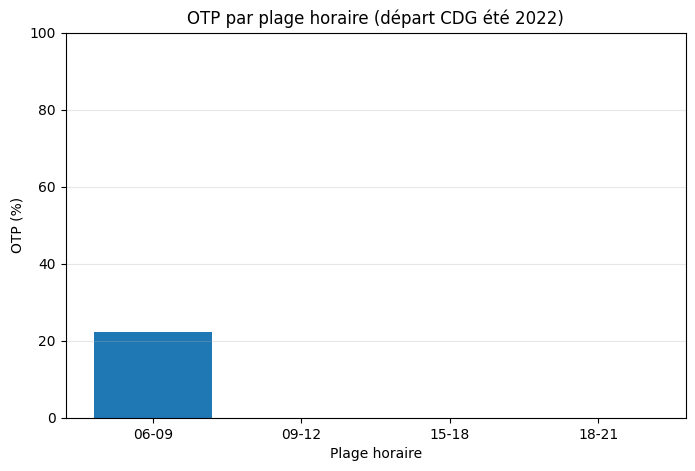

In [19]:
plt.figure(figsize=(8,5))
plt.bar(otp_par_plage["plage_horaire"], otp_par_plage["on_time"])
plt.title("OTP par plage horaire (départ CDG été 2022)")
plt.xlabel("Plage horaire")
plt.ylabel("OTP (%)")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3)
plt.show()


### Interprétation

Le graphique montre une situation très dégradée :

- La seule plage horaire avec un peu de ponctualité est **06–09**, avec environ **22% de vols à l’heure**.  
- Toutes les autres plages affichent **0% d’OTP**, ce qui indique qu’aucun vol n’a respecté la tolérance de 15 minutes sur ces créneaux.

Ce pattern suggère que les opérations démarrent déjà en difficulté au petit matin, puis se dégradent totalement au fil de la journée.  
Cela est typique d’une journée où les retards se **propagent en cascade**, notamment lors d’une crise bagages/handling comme celle de l’été 2022 à CDG.


## OTP par terminal

J’analyse ici la ponctualité (OTP) selon les terminaux du hub.  
L’objectif est d’identifier les zones où les opérations aériennes sont les plus perturbées.

Cette segmentation permet de repérer les terminaux nécessitant :
- un renfort de ressources,
- un meilleur pilotage des opérations sol,
- ou une analyse plus fine des goulets d’étranglement.


In [20]:
otp_terminal = (
    df.groupby("terminal")["on_time"]
    .mean().mul(100)
    .reset_index()
    .sort_values("on_time")
)

otp_terminal


,terminal,on_time
0,2E,0.000000
2,2G,0.000000
1,2F,33.333333


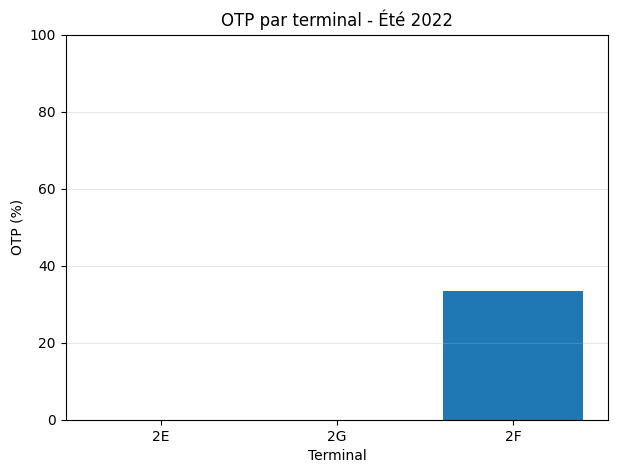

In [21]:
plt.figure(figsize=(7,5))
plt.bar(otp_terminal["terminal"], otp_terminal["on_time"])
plt.title("OTP par terminal - Été 2022")
plt.xlabel("Terminal")
plt.ylabel("OTP (%)")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3)
plt.show()


In [25]:
cause_counts = (
    df["code_retard_principal"]
    .value_counts()                      # 1) compte combien de fois chaque cause apparaît
    .reset_index(name="nombre_vols")     # 2) transforme en DataFrame + nomme la colonne des comptes
    .rename(columns={"index": "code_retard_principal"})  # 3) renomme la colonne des causes
)

cause_counts


,code_retard_principal,nombre_vols
0,BAGAGES,6
1,SECURITE,2
2,HANDLING,2
3,ATC,2
4,ROTATION,1
5,METEO,1
6,AUTRE,1


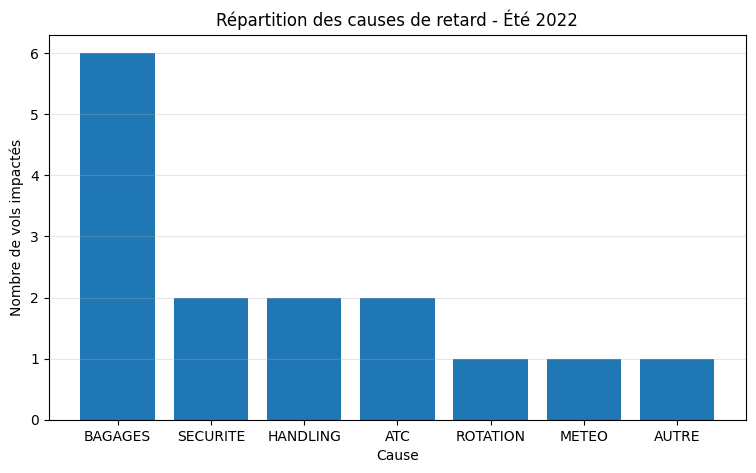

In [26]:
plt.figure(figsize=(9,5))
plt.bar(cause_counts["code_retard_principal"], cause_counts["nombre_vols"])
plt.title("Répartition des causes de retard - Été 2022")
plt.xlabel("Cause")
plt.ylabel("Nombre de vols impactés")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [28]:
df["cause_interne_bool"] = df["cause_interne"] == 1

part_interne_externe = (
    df.groupby("cause_interne_bool")["flight_id"]
    .count()
    .reset_index()
    .rename(columns={"flight_id": "nb_vols"})
)

part_interne_externe


,cause_interne_bool,nb_vols
0,False,3
1,True,12


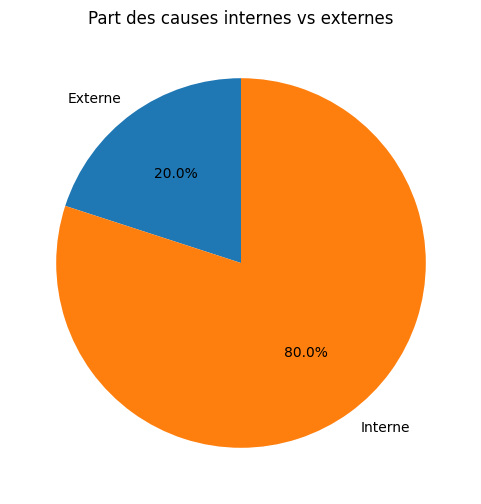

In [29]:
labels = ["Externe", "Interne"]

plt.figure(figsize=(6,6))
plt.pie(
    part_interne_externe["nb_vols"],
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Part des causes internes vs externes")
plt.show()
